In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn 
import torch.optim as optim

import copy
import tqdm

import util
import os 

In [2]:
cwd = os.getcwd()
print(cwd)

/home/linhnm/msc_code/big_data_mining/eabdt/python


In [3]:
dataset = 'mix'

training_batch_from = 0
training_batch_to = 3000
val_batch_from = 3000
val_batch_to = 3600

testing_batch_from = 0
testing_batch_to = 400

# training_batch_from = 0
# training_batch_to = 40
# val_batch_from = 40
# val_batch_to = 50

# testing_batch_from = 0
# testing_batch_to = 8

In [4]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda:0'
  print('ok')

ok


In [5]:
X_train = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/training_set'), training_batch_from, training_batch_to)
y_train = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), training_batch_from, training_batch_to)

X_val = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/training_set'), val_batch_from, val_batch_to)
y_val = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), val_batch_from, val_batch_to)

X_test = util.load_vector(os.path.join(cwd, '../data/vectorize/384/mix/testing_set'), testing_batch_from, testing_batch_to)
y_test = util.load_label(os.path.join(cwd, '../data/raw/mix/testing_set'), testing_batch_from, testing_batch_to)

In [6]:
X_train.shape

(3000000, 384)

In [7]:
epochs = 200
trigger = 1
early_stopping_round = 20

input_dim = 384
# input_dim = 768
output_dim = 1
learning_rate = 0.1

In [8]:
class Softmax(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Softmax, self).__init__()
    # hidden layer 
    self.linear_1 = torch.nn.Linear(input_dim, 128, bias=True)
    self.linear_2 = torch.nn.Linear(128, 64, bias=True) 
    self.linear_3 = torch.nn.Linear(64, output_dim) 
    # defining layers as attributes
    self.layer_in = None
    self.act = None
    self.layer_out = None
  def forward(self, x):
    self.layer_in_1 = self.linear_1(x)
    self.act_1 = torch.relu(self.layer_in_1)
    self.layer_in_2 = self.linear_2(self.act_1)
    self.act_2 = torch.relu(self.layer_in_2)
    self.layer_out = self.linear_3(self.act_2)
    y_pred = torch.sigmoid(self.linear_3(self.act_2))
    return y_pred

In [9]:
model = Softmax(input_dim, output_dim)
model.to(device)

Softmax(
  (linear_1): Linear(in_features=384, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# X_gpu_train = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_gpu_train = torch.flatten(torch.tensor(y_train).type(torch.float32)).to(device)
X_gpu_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_gpu_val = torch.flatten(torch.tensor(y_val).type(torch.float32)).to(device)
X_gpu_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_gpu_test = torch.flatten(torch.tensor(y_test).type(torch.float32)).to(device)

In [12]:
import time
tol_acc = 2
warming = 20
losses = []
losses_val = []
acc_train = []
acc_val = []
Iterations = []
best_loss = torch.tensor(np.inf).to(device)
best_acc = 0
best_weights = None
iter = 0
early = 0
start = time.time()
mini_batch_size = 1024
num_mini_batch = int(X_train.shape[0] / mini_batch_size)
# X_gpu_train_shuffle = X_gpu_train
for epoch in tqdm.tqdm(range(int(epochs)),desc='Training Epochs'):
    
    for bid in range(num_mini_batch):
        idx = np.random.randint(X_train.shape[0], size=mini_batch_size)
        X_train_batch = X_train[idx, :]
        x = torch.tensor(X_train_batch, dtype=torch.float32).to(device)
        # indices = torch.randperm(X_gpu_train.shape[0])[:mini_batch_size]
        # x = X_gpu_train[indices]
    
        # start = time.time()
        # x = X_gpu_train
        # labels = y_gpu_train[indices]
        y_train_batch = y_train[idx]
        labels = torch.flatten(torch.tensor(y_train_batch).type(torch.float32)).to(device)
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
        # print(f"Train -  Loss: {loss.item()}, batch: {bid}")
    
    iter+=1
    early+=1
    if iter%trigger==0:
        early+=1
        with torch.no_grad():
            # Calculating the loss and accuracy for the val dataset
            correct_val = 0
            total_val = 0
            outputs_val = torch.squeeze(model(X_gpu_val))
            loss_val = criterion(outputs_val, y_gpu_val)
            
            # predicted_val = outputs_val.round()
            total_val += y_gpu_val.size(0)
            correct_val += torch.eq(outputs_val.round(), y_gpu_val).sum()
            accuracy_val = 100 * correct_val/total_val
            losses_val.append(loss_val.item())
            acc_val.append(accuracy_val.item())
            
            # Calculating the loss and accuracy for the train dataset
            # total = 0
            # correct = 0
            # total += y_gpu_train.size(0)
            # # correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_gpu_train.detach().numpy())
            # correct += torch.eq(torch.squeeze(outputs).round(), y_gpu_train).sum()
            # accuracy = 100 * correct/total
            # losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nVal - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")
            # print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
            
            if accuracy_val > best_acc:
                print(f'\tBetter accuracy: {accuracy_val}')
                best_acc = accuracy_val
                best_weights = copy.deepcopy(model.state_dict())
            elif epoch > warming and (best_acc - accuracy_val) > tol_acc:
                print(f'early stopping, current accuracy: {accuracy_val}')
                break    

            # if (early%early_stopping_round == 0) and (loss_val > torch.min(torch.tensor(losses_val[-4:-1]))):
            #     print(f'Early stopping, loss val: {loss_val}')
            #     break
            
end = time.time()
total_time = round(end - start, 3)


Training Epochs:   0%|          | 1/200 [00:04<14:45,  4.45s/it]

Iteration: 1. 
Val - Loss: 0.32605963945388794. Accuracy: 86.14099884033203
	Better accuracy: 86.14099884033203


Training Epochs:   1%|          | 2/200 [00:08<13:42,  4.15s/it]

Iteration: 2. 
Val - Loss: 0.32135477662086487. Accuracy: 86.28199768066406
	Better accuracy: 86.28199768066406


Training Epochs:   2%|▏         | 3/200 [00:12<13:23,  4.08s/it]

Iteration: 3. 
Val - Loss: 0.30167436599731445. Accuracy: 87.24266815185547
	Better accuracy: 87.24266815185547


Training Epochs:   2%|▏         | 4/200 [00:16<13:03,  4.00s/it]

Iteration: 4. 
Val - Loss: 0.3032003939151764. Accuracy: 87.11016845703125


Training Epochs:   2%|▎         | 5/200 [00:20<12:53,  3.97s/it]

Iteration: 5. 
Val - Loss: 0.28466054797172546. Accuracy: 88.05750274658203
	Better accuracy: 88.05750274658203


Training Epochs:   3%|▎         | 6/200 [00:24<12:43,  3.94s/it]

Iteration: 6. 
Val - Loss: 0.29990503191947937. Accuracy: 87.31199645996094


Training Epochs:   4%|▎         | 7/200 [00:27<12:32,  3.90s/it]

Iteration: 7. 
Val - Loss: 0.27387937903404236. Accuracy: 88.62433624267578
	Better accuracy: 88.62433624267578


Training Epochs:   4%|▍         | 8/200 [00:31<12:31,  3.91s/it]

Iteration: 8. 
Val - Loss: 0.278176486492157. Accuracy: 88.4001693725586


Training Epochs:   4%|▍         | 9/200 [00:35<12:24,  3.90s/it]

Iteration: 9. 
Val - Loss: 0.2698928117752075. Accuracy: 88.80699920654297
	Better accuracy: 88.80699920654297


Training Epochs:   5%|▌         | 10/200 [00:39<12:20,  3.90s/it]

Iteration: 10. 
Val - Loss: 0.27579689025878906. Accuracy: 88.48233032226562


Training Epochs:   6%|▌         | 11/200 [00:43<12:15,  3.89s/it]

Iteration: 11. 
Val - Loss: 0.2661820352077484. Accuracy: 88.9991683959961
	Better accuracy: 88.9991683959961


Training Epochs:   6%|▌         | 12/200 [00:47<12:14,  3.91s/it]

Iteration: 12. 
Val - Loss: 0.2635338604450226. Accuracy: 89.11483001708984
	Better accuracy: 89.11483001708984


Training Epochs:   6%|▋         | 13/200 [00:51<12:18,  3.95s/it]

Iteration: 13. 
Val - Loss: 0.2625837028026581. Accuracy: 89.13533020019531
	Better accuracy: 89.13533020019531


Training Epochs:   7%|▋         | 14/200 [00:55<12:20,  3.98s/it]

Iteration: 14. 
Val - Loss: 0.26209816336631775. Accuracy: 89.16100311279297
	Better accuracy: 89.16100311279297


Training Epochs:   8%|▊         | 15/200 [00:59<12:10,  3.95s/it]

Iteration: 15. 
Val - Loss: 0.26045772433280945. Accuracy: 89.25150299072266
	Better accuracy: 89.25150299072266


Training Epochs:   8%|▊         | 16/200 [01:03<12:05,  3.94s/it]

Iteration: 16. 
Val - Loss: 0.27125194668769836. Accuracy: 88.74366760253906


Training Epochs:   8%|▊         | 17/200 [01:07<12:05,  3.96s/it]

Iteration: 17. 
Val - Loss: 0.2600844204425812. Accuracy: 89.2665023803711
	Better accuracy: 89.2665023803711


Training Epochs:   9%|▉         | 18/200 [01:11<12:07,  4.00s/it]

Iteration: 18. 
Val - Loss: 0.25763311982154846. Accuracy: 89.38416290283203
	Better accuracy: 89.38416290283203


Training Epochs:  10%|▉         | 19/200 [01:15<12:10,  4.04s/it]

Iteration: 19. 
Val - Loss: 0.2631020247936249. Accuracy: 89.10616302490234


Training Epochs:  10%|█         | 20/200 [01:19<12:08,  4.05s/it]

Iteration: 20. 
Val - Loss: 0.25905320048332214. Accuracy: 89.30633544921875


Training Epochs:  10%|█         | 21/200 [01:23<12:02,  4.03s/it]

Iteration: 21. 
Val - Loss: 0.2647426426410675. Accuracy: 89.00533294677734


Training Epochs:  11%|█         | 22/200 [01:27<11:55,  4.02s/it]

Iteration: 22. 
Val - Loss: 0.25613531470298767. Accuracy: 89.45133209228516
	Better accuracy: 89.45133209228516


Training Epochs:  12%|█▏        | 23/200 [01:31<11:53,  4.03s/it]

Iteration: 23. 
Val - Loss: 0.2556065320968628. Accuracy: 89.47249603271484
	Better accuracy: 89.47249603271484


Training Epochs:  12%|█▏        | 24/200 [01:35<11:50,  4.04s/it]

Iteration: 24. 
Val - Loss: 0.2553374171257019. Accuracy: 89.48683166503906
	Better accuracy: 89.48683166503906


Training Epochs:  12%|█▎        | 25/200 [01:39<11:39,  4.00s/it]

Iteration: 25. 
Val - Loss: 0.2540169358253479. Accuracy: 89.55316925048828
	Better accuracy: 89.55316925048828


Training Epochs:  13%|█▎        | 26/200 [01:43<11:35,  4.00s/it]

Iteration: 26. 
Val - Loss: 0.2542573809623718. Accuracy: 89.517333984375


Training Epochs:  14%|█▎        | 27/200 [01:47<11:29,  3.98s/it]

Iteration: 27. 
Val - Loss: 0.2591032385826111. Accuracy: 89.28299713134766


Training Epochs:  14%|█▍        | 28/200 [01:51<11:21,  3.96s/it]

Iteration: 28. 
Val - Loss: 0.25358808040618896. Accuracy: 89.54850006103516


Training Epochs:  14%|█▍        | 29/200 [01:55<11:19,  3.97s/it]

Iteration: 29. 
Val - Loss: 0.2563914954662323. Accuracy: 89.41383361816406


Training Epochs:  15%|█▌        | 30/200 [01:59<11:18,  3.99s/it]

Iteration: 30. 
Val - Loss: 0.25305724143981934. Accuracy: 89.5634994506836
	Better accuracy: 89.5634994506836


Training Epochs:  16%|█▌        | 31/200 [02:03<11:20,  4.02s/it]

Iteration: 31. 
Val - Loss: 0.25264912843704224. Accuracy: 89.6050033569336
	Better accuracy: 89.6050033569336


Training Epochs:  16%|█▌        | 32/200 [02:07<11:10,  3.99s/it]

Iteration: 32. 
Val - Loss: 0.25219738483428955. Accuracy: 89.60832977294922
	Better accuracy: 89.60832977294922


Training Epochs:  16%|█▋        | 33/200 [02:11<11:10,  4.02s/it]

Iteration: 33. 
Val - Loss: 0.2521316707134247. Accuracy: 89.61083221435547
	Better accuracy: 89.61083221435547


Training Epochs:  17%|█▋        | 34/200 [02:15<11:05,  4.01s/it]

Iteration: 34. 
Val - Loss: 0.2551056146621704. Accuracy: 89.4905014038086


Training Epochs:  18%|█▊        | 35/200 [02:19<11:02,  4.01s/it]

Iteration: 35. 
Val - Loss: 0.25193506479263306. Accuracy: 89.6318359375
	Better accuracy: 89.6318359375


Training Epochs:  18%|█▊        | 36/200 [02:23<11:03,  4.05s/it]

Iteration: 36. 
Val - Loss: 0.25152748823165894. Accuracy: 89.63999938964844
	Better accuracy: 89.63999938964844


Training Epochs:  18%|█▊        | 37/200 [02:27<10:57,  4.03s/it]

Iteration: 37. 
Val - Loss: 0.25456151366233826. Accuracy: 89.51433563232422


Training Epochs:  19%|█▉        | 38/200 [02:31<10:57,  4.06s/it]

Iteration: 38. 
Val - Loss: 0.2537849545478821. Accuracy: 89.53600311279297


Training Epochs:  20%|█▉        | 39/200 [02:35<10:49,  4.04s/it]

Iteration: 39. 
Val - Loss: 0.25122493505477905. Accuracy: 89.65916442871094
	Better accuracy: 89.65916442871094


Training Epochs:  20%|██        | 40/200 [02:39<10:45,  4.03s/it]

Iteration: 40. 
Val - Loss: 0.25230562686920166. Accuracy: 89.60449981689453


Training Epochs:  20%|██        | 41/200 [02:43<10:37,  4.01s/it]

Iteration: 41. 
Val - Loss: 0.2512228190898895. Accuracy: 89.65066528320312


Training Epochs:  21%|██        | 42/200 [02:47<10:30,  3.99s/it]

Iteration: 42. 
Val - Loss: 0.2509702742099762. Accuracy: 89.64833068847656


Training Epochs:  22%|██▏       | 43/200 [02:51<10:28,  4.01s/it]

Iteration: 43. 
Val - Loss: 0.2512896656990051. Accuracy: 89.65483093261719


Training Epochs:  22%|██▏       | 44/200 [02:55<10:21,  3.98s/it]

Iteration: 44. 
Val - Loss: 0.2529250383377075. Accuracy: 89.57266998291016


Training Epochs:  22%|██▎       | 45/200 [02:59<10:20,  4.00s/it]

Iteration: 45. 
Val - Loss: 0.2527945935726166. Accuracy: 89.57416534423828


Training Epochs:  23%|██▎       | 46/200 [03:03<10:11,  3.97s/it]

Iteration: 46. 
Val - Loss: 0.2518870234489441. Accuracy: 89.63616943359375


Training Epochs:  24%|██▎       | 47/200 [03:07<10:14,  4.02s/it]

Iteration: 47. 
Val - Loss: 0.2504787743091583. Accuracy: 89.69983673095703
	Better accuracy: 89.69983673095703


Training Epochs:  24%|██▍       | 48/200 [03:11<10:07,  3.99s/it]

Iteration: 48. 
Val - Loss: 0.2510899305343628. Accuracy: 89.67250061035156


Training Epochs:  24%|██▍       | 49/200 [03:15<10:06,  4.02s/it]

Iteration: 49. 
Val - Loss: 0.2511955797672272. Accuracy: 89.65166473388672


Training Epochs:  25%|██▌       | 50/200 [03:19<10:01,  4.01s/it]

Iteration: 50. 
Val - Loss: 0.2511483430862427. Accuracy: 89.66283416748047


Training Epochs:  26%|██▌       | 51/200 [03:23<09:59,  4.03s/it]

Iteration: 51. 
Val - Loss: 0.259573370218277. Accuracy: 89.24783325195312


Training Epochs:  26%|██▌       | 52/200 [03:27<09:54,  4.02s/it]

Iteration: 52. 
Val - Loss: 0.2503040134906769. Accuracy: 89.69232940673828


Training Epochs:  26%|██▋       | 53/200 [03:31<09:50,  4.02s/it]

Iteration: 53. 
Val - Loss: 0.2507931888103485. Accuracy: 89.66400146484375


Training Epochs:  27%|██▋       | 54/200 [03:35<09:46,  4.02s/it]

Iteration: 54. 
Val - Loss: 0.250173956155777. Accuracy: 89.6951675415039


Training Epochs:  28%|██▊       | 55/200 [03:39<09:45,  4.04s/it]

Iteration: 55. 
Val - Loss: 0.2524120807647705. Accuracy: 89.60700225830078


Training Epochs:  28%|██▊       | 56/200 [03:43<09:37,  4.01s/it]

Iteration: 56. 
Val - Loss: 0.2590895891189575. Accuracy: 89.27083587646484


Training Epochs:  28%|██▊       | 57/200 [03:47<09:35,  4.02s/it]

Iteration: 57. 
Val - Loss: 0.25424203276634216. Accuracy: 89.54833221435547


Training Epochs:  29%|██▉       | 58/200 [03:52<09:33,  4.04s/it]

Iteration: 58. 
Val - Loss: 0.24997517466545105. Accuracy: 89.68766784667969


Training Epochs:  30%|██▉       | 59/200 [03:55<09:26,  4.02s/it]

Iteration: 59. 
Val - Loss: 0.252078652381897. Accuracy: 89.61683654785156


Training Epochs:  30%|███       | 60/200 [03:59<09:14,  3.96s/it]

Iteration: 60. 
Val - Loss: 0.24976056814193726. Accuracy: 89.7040023803711
	Better accuracy: 89.7040023803711


Training Epochs:  30%|███       | 61/200 [04:03<09:17,  4.01s/it]

Iteration: 61. 
Val - Loss: 0.25014930963516235. Accuracy: 89.68367004394531


Training Epochs:  31%|███       | 62/200 [04:08<09:15,  4.02s/it]

Iteration: 62. 
Val - Loss: 0.25037890672683716. Accuracy: 89.66283416748047


Training Epochs:  32%|███▏      | 63/200 [04:12<09:14,  4.05s/it]

Iteration: 63. 
Val - Loss: 0.24983958899974823. Accuracy: 89.69249725341797


Training Epochs:  32%|███▏      | 64/200 [04:16<09:08,  4.03s/it]

Iteration: 64. 
Val - Loss: 0.25089845061302185. Accuracy: 89.71033477783203
	Better accuracy: 89.71033477783203


Training Epochs:  32%|███▎      | 65/200 [04:20<08:58,  3.99s/it]

Iteration: 65. 
Val - Loss: 0.263507604598999. Accuracy: 89.1181640625


Training Epochs:  33%|███▎      | 66/200 [04:24<08:58,  4.02s/it]

Iteration: 66. 
Val - Loss: 0.25240424275398254. Accuracy: 89.59449768066406


Training Epochs:  34%|███▎      | 67/200 [04:27<08:49,  3.98s/it]

Iteration: 67. 
Val - Loss: 0.24990087747573853. Accuracy: 89.72383117675781
	Better accuracy: 89.72383117675781


Training Epochs:  34%|███▍      | 68/200 [04:32<08:48,  4.00s/it]

Iteration: 68. 
Val - Loss: 0.24971911311149597. Accuracy: 89.704833984375


Training Epochs:  34%|███▍      | 69/200 [04:36<08:46,  4.02s/it]

Iteration: 69. 
Val - Loss: 0.2501501441001892. Accuracy: 89.70933532714844


Training Epochs:  35%|███▌      | 70/200 [04:40<08:39,  4.00s/it]

Iteration: 70. 
Val - Loss: 0.25007644295692444. Accuracy: 89.72083282470703


Training Epochs:  36%|███▌      | 71/200 [04:44<08:36,  4.01s/it]

Iteration: 71. 
Val - Loss: 0.2498674988746643. Accuracy: 89.7038345336914


Training Epochs:  36%|███▌      | 72/200 [04:48<08:33,  4.01s/it]

Iteration: 72. 
Val - Loss: 0.25094926357269287. Accuracy: 89.65833282470703


Training Epochs:  36%|███▋      | 73/200 [04:52<08:27,  4.00s/it]

Iteration: 73. 
Val - Loss: 0.25336208939552307. Accuracy: 89.58866882324219


Training Epochs:  37%|███▋      | 74/200 [04:56<08:24,  4.01s/it]

Iteration: 74. 
Val - Loss: 0.2491445243358612. Accuracy: 89.75516510009766
	Better accuracy: 89.75516510009766


Training Epochs:  38%|███▊      | 75/200 [04:59<08:12,  3.94s/it]

Iteration: 75. 
Val - Loss: 0.25654926896095276. Accuracy: 89.43450164794922


Training Epochs:  38%|███▊      | 76/200 [05:03<08:10,  3.96s/it]

Iteration: 76. 
Val - Loss: 0.26578572392463684. Accuracy: 88.90433502197266


Training Epochs:  38%|███▊      | 77/200 [05:07<07:58,  3.89s/it]

Iteration: 77. 
Val - Loss: 0.250822514295578. Accuracy: 89.69132995605469


Training Epochs:  39%|███▉      | 78/200 [05:11<07:52,  3.88s/it]

Iteration: 78. 
Val - Loss: 0.24950917065143585. Accuracy: 89.73899841308594


Training Epochs:  40%|███▉      | 79/200 [05:15<07:51,  3.89s/it]

Iteration: 79. 
Val - Loss: 0.24917931854724884. Accuracy: 89.75166320800781


Training Epochs:  40%|████      | 80/200 [05:19<07:52,  3.94s/it]

Iteration: 80. 
Val - Loss: 0.25170040130615234. Accuracy: 89.62166595458984


Training Epochs:  40%|████      | 81/200 [05:23<07:50,  3.96s/it]

Iteration: 81. 
Val - Loss: 0.2509586811065674. Accuracy: 89.63833618164062


Training Epochs:  41%|████      | 82/200 [05:27<07:48,  3.97s/it]

Iteration: 82. 
Val - Loss: 0.25412923097610474. Accuracy: 89.51333618164062


Training Epochs:  42%|████▏     | 83/200 [05:31<07:49,  4.02s/it]

Iteration: 83. 
Val - Loss: 0.2548966109752655. Accuracy: 89.42416381835938


Training Epochs:  42%|████▏     | 84/200 [05:35<07:45,  4.01s/it]

Iteration: 84. 
Val - Loss: 0.25006693601608276. Accuracy: 89.69416809082031


Training Epochs:  42%|████▎     | 85/200 [05:39<07:40,  4.00s/it]

Iteration: 85. 
Val - Loss: 0.2494649738073349. Accuracy: 89.76100158691406
	Better accuracy: 89.76100158691406


Training Epochs:  43%|████▎     | 86/200 [05:43<07:34,  3.99s/it]

Iteration: 86. 
Val - Loss: 0.24878567457199097. Accuracy: 89.7614974975586
	Better accuracy: 89.7614974975586


Training Epochs:  44%|████▎     | 87/200 [05:47<07:32,  4.01s/it]

Iteration: 87. 
Val - Loss: 0.25026100873947144. Accuracy: 89.69733428955078


Training Epochs:  44%|████▍     | 88/200 [05:51<07:26,  3.99s/it]

Iteration: 88. 
Val - Loss: 0.24891796708106995. Accuracy: 89.77733612060547
	Better accuracy: 89.77733612060547


Training Epochs:  44%|████▍     | 89/200 [05:55<07:26,  4.02s/it]

Iteration: 89. 
Val - Loss: 0.24978215992450714. Accuracy: 89.7308349609375


Training Epochs:  45%|████▌     | 90/200 [05:59<07:20,  4.00s/it]

Iteration: 90. 
Val - Loss: 0.24907515943050385. Accuracy: 89.73433685302734


Training Epochs:  46%|████▌     | 91/200 [06:03<07:15,  4.00s/it]

Iteration: 91. 
Val - Loss: 0.2503302991390228. Accuracy: 89.72333526611328


Training Epochs:  46%|████▌     | 92/200 [06:07<07:12,  4.01s/it]

Iteration: 92. 
Val - Loss: 0.25414520502090454. Accuracy: 89.52083587646484


Training Epochs:  46%|████▋     | 93/200 [06:11<07:08,  4.00s/it]

Iteration: 93. 
Val - Loss: 0.2506175637245178. Accuracy: 89.70849609375


Training Epochs:  47%|████▋     | 94/200 [06:15<07:03,  4.00s/it]

Iteration: 94. 
Val - Loss: 0.24913842976093292. Accuracy: 89.74983215332031


Training Epochs:  48%|████▊     | 95/200 [06:19<06:59,  3.99s/it]

Iteration: 95. 
Val - Loss: 0.24933403730392456. Accuracy: 89.74366760253906


Training Epochs:  48%|████▊     | 96/200 [06:23<06:51,  3.96s/it]

Iteration: 96. 
Val - Loss: 0.25098949670791626. Accuracy: 89.6760025024414


Training Epochs:  48%|████▊     | 97/200 [06:27<06:52,  4.01s/it]

Iteration: 97. 
Val - Loss: 0.2491435408592224. Accuracy: 89.75316619873047


Training Epochs:  49%|████▉     | 98/200 [06:31<06:47,  3.99s/it]

Iteration: 98. 
Val - Loss: 0.25615194439888. Accuracy: 89.4471664428711


Training Epochs:  50%|████▉     | 99/200 [06:35<06:44,  4.00s/it]

Iteration: 99. 
Val - Loss: 0.2502605617046356. Accuracy: 89.71800231933594


Training Epochs:  50%|█████     | 100/200 [06:39<06:39,  4.00s/it]

Iteration: 100. 
Val - Loss: 0.2507915496826172. Accuracy: 89.70266723632812


Training Epochs:  50%|█████     | 101/200 [06:43<06:37,  4.01s/it]

Iteration: 101. 
Val - Loss: 0.24924997985363007. Accuracy: 89.75833129882812


Training Epochs:  51%|█████     | 102/200 [06:47<06:32,  4.00s/it]

Iteration: 102. 
Val - Loss: 0.2519865036010742. Accuracy: 89.62200164794922


Training Epochs:  52%|█████▏    | 103/200 [06:51<06:28,  4.00s/it]

Iteration: 103. 
Val - Loss: 0.2518075108528137. Accuracy: 89.62516784667969


Training Epochs:  52%|█████▏    | 104/200 [06:55<06:27,  4.03s/it]

Iteration: 104. 
Val - Loss: 0.24931947886943817. Accuracy: 89.732666015625


Training Epochs:  52%|█████▎    | 105/200 [06:59<06:25,  4.06s/it]

Iteration: 105. 
Val - Loss: 0.24933800101280212. Accuracy: 89.73916625976562


Training Epochs:  53%|█████▎    | 106/200 [07:03<06:21,  4.05s/it]

Iteration: 106. 
Val - Loss: 0.24865669012069702. Accuracy: 89.77166748046875


Training Epochs:  54%|█████▎    | 107/200 [07:07<06:13,  4.02s/it]

Iteration: 107. 
Val - Loss: 0.24861693382263184. Accuracy: 89.760498046875


Training Epochs:  54%|█████▍    | 108/200 [07:11<06:07,  4.00s/it]

Iteration: 108. 
Val - Loss: 0.2531580328941345. Accuracy: 89.5770034790039


Training Epochs:  55%|█████▍    | 109/200 [07:15<06:02,  3.99s/it]

Iteration: 109. 
Val - Loss: 0.24936576187610626. Accuracy: 89.75450134277344


Training Epochs:  55%|█████▌    | 110/200 [07:19<06:00,  4.00s/it]

Iteration: 110. 
Val - Loss: 0.2490788996219635. Accuracy: 89.75166320800781


Training Epochs:  56%|█████▌    | 111/200 [07:23<05:54,  3.98s/it]

Iteration: 111. 
Val - Loss: 0.2509289085865021. Accuracy: 89.70883178710938


Training Epochs:  56%|█████▌    | 112/200 [07:27<05:49,  3.97s/it]

Iteration: 112. 
Val - Loss: 0.24956181645393372. Accuracy: 89.74533081054688


Training Epochs:  56%|█████▋    | 113/200 [07:31<05:44,  3.96s/it]

Iteration: 113. 
Val - Loss: 0.2501535415649414. Accuracy: 89.74983215332031


Training Epochs:  57%|█████▋    | 114/200 [07:35<05:41,  3.97s/it]

Iteration: 114. 
Val - Loss: 0.24878369271755219. Accuracy: 89.77383422851562


Training Epochs:  57%|█████▊    | 115/200 [07:39<05:36,  3.96s/it]

Iteration: 115. 
Val - Loss: 0.250095933675766. Accuracy: 89.7403335571289


Training Epochs:  58%|█████▊    | 116/200 [07:43<05:31,  3.95s/it]

Iteration: 116. 
Val - Loss: 0.24998942017555237. Accuracy: 89.70133209228516


Training Epochs:  58%|█████▊    | 117/200 [07:47<05:26,  3.94s/it]

Iteration: 117. 
Val - Loss: 0.2503008246421814. Accuracy: 89.70833587646484


Training Epochs:  59%|█████▉    | 118/200 [07:51<05:24,  3.96s/it]

Iteration: 118. 
Val - Loss: 0.2508842349052429. Accuracy: 89.69816589355469


Training Epochs:  60%|█████▉    | 119/200 [07:55<05:23,  3.99s/it]

Iteration: 119. 
Val - Loss: 0.24890562891960144. Accuracy: 89.7681655883789


Training Epochs:  60%|██████    | 120/200 [07:59<05:19,  4.00s/it]

Iteration: 120. 
Val - Loss: 0.25017428398132324. Accuracy: 89.72566986083984


Training Epochs:  60%|██████    | 121/200 [08:03<05:19,  4.04s/it]

Iteration: 121. 
Val - Loss: 0.249628484249115. Accuracy: 89.7403335571289


Training Epochs:  61%|██████    | 122/200 [08:07<05:14,  4.03s/it]

Iteration: 122. 
Val - Loss: 0.2516126334667206. Accuracy: 89.63883209228516


Training Epochs:  62%|██████▏   | 123/200 [08:11<05:10,  4.03s/it]

Iteration: 123. 
Val - Loss: 0.25105053186416626. Accuracy: 89.70016479492188


Training Epochs:  62%|██████▏   | 124/200 [08:15<05:06,  4.04s/it]

Iteration: 124. 
Val - Loss: 0.24976135790348053. Accuracy: 89.73533630371094


Training Epochs:  62%|██████▎   | 125/200 [08:19<05:03,  4.04s/it]

Iteration: 125. 
Val - Loss: 0.2489204704761505. Accuracy: 89.76416778564453


Training Epochs:  63%|██████▎   | 126/200 [08:23<04:58,  4.03s/it]

Iteration: 126. 
Val - Loss: 0.25073209404945374. Accuracy: 89.65733337402344


Training Epochs:  64%|██████▎   | 127/200 [08:27<04:52,  4.01s/it]

Iteration: 127. 
Val - Loss: 0.25150683522224426. Accuracy: 89.68250274658203


Training Epochs:  64%|██████▍   | 128/200 [08:31<04:46,  3.98s/it]

Iteration: 128. 
Val - Loss: 0.2490362524986267. Accuracy: 89.77149963378906


Training Epochs:  64%|██████▍   | 129/200 [08:35<04:44,  4.01s/it]

Iteration: 129. 
Val - Loss: 0.2495478093624115. Accuracy: 89.72949981689453


Training Epochs:  65%|██████▌   | 130/200 [08:39<04:42,  4.03s/it]

Iteration: 130. 
Val - Loss: 0.2533223330974579. Accuracy: 89.5556640625


Training Epochs:  66%|██████▌   | 131/200 [08:43<04:37,  4.01s/it]

Iteration: 131. 
Val - Loss: 0.24987578392028809. Accuracy: 89.71333312988281


Training Epochs:  66%|██████▌   | 132/200 [08:47<04:30,  3.98s/it]

Iteration: 132. 
Val - Loss: 0.251529335975647. Accuracy: 89.69200134277344


Training Epochs:  66%|██████▋   | 133/200 [08:51<04:27,  3.99s/it]

Iteration: 133. 
Val - Loss: 0.2498571276664734. Accuracy: 89.69933319091797


Training Epochs:  67%|██████▋   | 134/200 [08:55<04:22,  3.98s/it]

Iteration: 134. 
Val - Loss: 0.24990218877792358. Accuracy: 89.74633026123047


Training Epochs:  68%|██████▊   | 135/200 [08:59<04:17,  3.96s/it]

Iteration: 135. 
Val - Loss: 0.25115227699279785. Accuracy: 89.70316314697266


Training Epochs:  68%|██████▊   | 136/200 [09:03<04:13,  3.96s/it]

Iteration: 136. 
Val - Loss: 0.24925369024276733. Accuracy: 89.72149658203125


Training Epochs:  68%|██████▊   | 137/200 [09:07<04:09,  3.96s/it]

Iteration: 137. 
Val - Loss: 0.2507518529891968. Accuracy: 89.66699981689453


Training Epochs:  69%|██████▉   | 138/200 [09:11<04:08,  4.00s/it]

Iteration: 138. 
Val - Loss: 0.25035369396209717. Accuracy: 89.68733215332031


Training Epochs:  70%|██████▉   | 139/200 [09:15<04:04,  4.01s/it]

Iteration: 139. 
Val - Loss: 0.24962568283081055. Accuracy: 89.76016998291016


Training Epochs:  70%|███████   | 140/200 [09:19<03:59,  3.99s/it]

Iteration: 140. 
Val - Loss: 0.24958431720733643. Accuracy: 89.7471694946289


Training Epochs:  70%|███████   | 141/200 [09:23<03:55,  3.99s/it]

Iteration: 141. 
Val - Loss: 0.24942314624786377. Accuracy: 89.73200225830078


Training Epochs:  71%|███████   | 142/200 [09:27<03:51,  3.99s/it]

Iteration: 142. 
Val - Loss: 0.25017276406288147. Accuracy: 89.72416687011719


Training Epochs:  72%|███████▏  | 143/200 [09:31<03:45,  3.96s/it]

Iteration: 143. 
Val - Loss: 0.2502796947956085. Accuracy: 89.73750305175781


Training Epochs:  72%|███████▏  | 144/200 [09:35<03:43,  3.99s/it]

Iteration: 144. 
Val - Loss: 0.2502272129058838. Accuracy: 89.68583679199219


Training Epochs:  72%|███████▎  | 145/200 [09:39<03:36,  3.94s/it]

Iteration: 145. 
Val - Loss: 0.2519797086715698. Accuracy: 89.61316680908203


Training Epochs:  73%|███████▎  | 146/200 [09:43<03:32,  3.93s/it]

Iteration: 146. 
Val - Loss: 0.2500264644622803. Accuracy: 89.70983123779297


Training Epochs:  74%|███████▎  | 147/200 [09:47<03:30,  3.97s/it]

Iteration: 147. 
Val - Loss: 0.2507758140563965. Accuracy: 89.76249694824219


Training Epochs:  74%|███████▍  | 148/200 [09:50<03:23,  3.92s/it]

Iteration: 148. 
Val - Loss: 0.25441160798072815. Accuracy: 89.55833435058594


Training Epochs:  74%|███████▍  | 149/200 [09:54<03:19,  3.91s/it]

Iteration: 149. 
Val - Loss: 0.2503223419189453. Accuracy: 89.75516510009766


Training Epochs:  75%|███████▌  | 150/200 [09:58<03:16,  3.93s/it]

Iteration: 150. 
Val - Loss: 0.25245165824890137. Accuracy: 89.62733459472656


Training Epochs:  76%|███████▌  | 151/200 [10:02<03:11,  3.91s/it]

Iteration: 151. 
Val - Loss: 0.2492862045764923. Accuracy: 89.77183532714844


Training Epochs:  76%|███████▌  | 152/200 [10:06<03:08,  3.93s/it]

Iteration: 152. 
Val - Loss: 0.24937166273593903. Accuracy: 89.7786636352539
	Better accuracy: 89.7786636352539


Training Epochs:  76%|███████▋  | 153/200 [10:10<03:06,  3.97s/it]

Iteration: 153. 
Val - Loss: 0.2509613633155823. Accuracy: 89.69833374023438


Training Epochs:  77%|███████▋  | 154/200 [10:14<03:02,  3.96s/it]

Iteration: 154. 
Val - Loss: 0.24946853518486023. Accuracy: 89.73566436767578


Training Epochs:  78%|███████▊  | 155/200 [10:18<02:55,  3.90s/it]

Iteration: 155. 
Val - Loss: 0.24953415989875793. Accuracy: 89.75299835205078


Training Epochs:  78%|███████▊  | 156/200 [10:22<02:52,  3.93s/it]

Iteration: 156. 
Val - Loss: 0.25333085656166077. Accuracy: 89.5739974975586


Training Epochs:  78%|███████▊  | 157/200 [10:26<02:48,  3.91s/it]

Iteration: 157. 
Val - Loss: 0.2505640983581543. Accuracy: 89.66033172607422


Training Epochs:  79%|███████▉  | 158/200 [10:30<02:44,  3.93s/it]

Iteration: 158. 
Val - Loss: 0.2497950792312622. Accuracy: 89.767333984375


Training Epochs:  80%|███████▉  | 159/200 [10:34<02:42,  3.95s/it]

Iteration: 159. 
Val - Loss: 0.25186318159103394. Accuracy: 89.66766357421875


Training Epochs:  80%|████████  | 160/200 [10:38<02:37,  3.95s/it]

Iteration: 160. 
Val - Loss: 0.25037500262260437. Accuracy: 89.67433166503906


Training Epochs:  80%|████████  | 161/200 [10:42<02:35,  3.99s/it]

Iteration: 161. 
Val - Loss: 0.2510179579257965. Accuracy: 89.63600158691406


Training Epochs:  81%|████████  | 162/200 [10:46<02:31,  4.00s/it]

Iteration: 162. 
Val - Loss: 0.2489379644393921. Accuracy: 89.75433349609375


Training Epochs:  82%|████████▏ | 163/200 [10:50<02:26,  3.96s/it]

Iteration: 163. 
Val - Loss: 0.25049057602882385. Accuracy: 89.68633270263672


Training Epochs:  82%|████████▏ | 164/200 [10:54<02:23,  3.98s/it]

Iteration: 164. 
Val - Loss: 0.2525738477706909. Accuracy: 89.64083099365234


Training Epochs:  82%|████████▎ | 165/200 [10:58<02:18,  3.97s/it]

Iteration: 165. 
Val - Loss: 0.2501288056373596. Accuracy: 89.774169921875


Training Epochs:  83%|████████▎ | 166/200 [11:02<02:15,  3.98s/it]

Iteration: 166. 
Val - Loss: 0.24979427456855774. Accuracy: 89.77149963378906


Training Epochs:  84%|████████▎ | 167/200 [11:05<02:10,  3.94s/it]

Iteration: 167. 
Val - Loss: 0.2542296051979065. Accuracy: 89.58399963378906


Training Epochs:  84%|████████▍ | 168/200 [11:09<02:06,  3.96s/it]

Iteration: 168. 
Val - Loss: 0.24902768433094025. Accuracy: 89.78499603271484
	Better accuracy: 89.78499603271484


Training Epochs:  84%|████████▍ | 169/200 [11:13<02:02,  3.96s/it]

Iteration: 169. 
Val - Loss: 0.24895867705345154. Accuracy: 89.78900146484375
	Better accuracy: 89.78900146484375


Training Epochs:  85%|████████▌ | 170/200 [11:17<01:59,  3.97s/it]

Iteration: 170. 
Val - Loss: 0.25001052021980286. Accuracy: 89.76433563232422


Training Epochs:  86%|████████▌ | 171/200 [11:21<01:54,  3.94s/it]

Iteration: 171. 
Val - Loss: 0.24969176948070526. Accuracy: 89.74333190917969


Training Epochs:  86%|████████▌ | 172/200 [11:25<01:50,  3.93s/it]

Iteration: 172. 
Val - Loss: 0.2518523037433624. Accuracy: 89.67749786376953


Training Epochs:  86%|████████▋ | 173/200 [11:29<01:46,  3.95s/it]

Iteration: 173. 
Val - Loss: 0.2501349151134491. Accuracy: 89.71649932861328


Training Epochs:  87%|████████▋ | 174/200 [11:33<01:41,  3.92s/it]

Iteration: 174. 
Val - Loss: 0.24995732307434082. Accuracy: 89.7125015258789


Training Epochs:  88%|████████▊ | 175/200 [11:37<01:38,  3.93s/it]

Iteration: 175. 
Val - Loss: 0.2496861219406128. Accuracy: 89.7508316040039


Training Epochs:  88%|████████▊ | 176/200 [11:41<01:33,  3.91s/it]

Iteration: 176. 
Val - Loss: 0.25475525856018066. Accuracy: 89.58216857910156


Training Epochs:  88%|████████▊ | 177/200 [11:45<01:30,  3.93s/it]

Iteration: 177. 
Val - Loss: 0.2519175410270691. Accuracy: 89.67949676513672


Training Epochs:  89%|████████▉ | 178/200 [11:49<01:26,  3.95s/it]

Iteration: 178. 
Val - Loss: 0.25154373049736023. Accuracy: 89.6364974975586


Training Epochs:  90%|████████▉ | 179/200 [11:53<01:23,  3.97s/it]

Iteration: 179. 
Val - Loss: 0.2515718936920166. Accuracy: 89.65899658203125


Training Epochs:  90%|█████████ | 180/200 [11:57<01:19,  3.98s/it]

Iteration: 180. 
Val - Loss: 0.24981214106082916. Accuracy: 89.74366760253906


Training Epochs:  90%|█████████ | 181/200 [12:01<01:16,  4.00s/it]

Iteration: 181. 
Val - Loss: 0.2493882030248642. Accuracy: 89.75333404541016


Training Epochs:  91%|█████████ | 182/200 [12:05<01:11,  4.00s/it]

Iteration: 182. 
Val - Loss: 0.25105348229408264. Accuracy: 89.68367004394531


Training Epochs:  92%|█████████▏| 183/200 [12:09<01:07,  3.95s/it]

Iteration: 183. 
Val - Loss: 0.25014790892601013. Accuracy: 89.73533630371094


Training Epochs:  92%|█████████▏| 184/200 [12:13<01:03,  3.95s/it]

Iteration: 184. 
Val - Loss: 0.2497074007987976. Accuracy: 89.7509994506836


Training Epochs:  92%|█████████▎| 185/200 [12:17<00:59,  3.97s/it]

Iteration: 185. 
Val - Loss: 0.251444935798645. Accuracy: 89.66633605957031


Training Epochs:  93%|█████████▎| 186/200 [12:21<00:55,  3.96s/it]

Iteration: 186. 
Val - Loss: 0.25042104721069336. Accuracy: 89.71983337402344


Training Epochs:  94%|█████████▎| 187/200 [12:25<00:51,  3.97s/it]

Iteration: 187. 
Val - Loss: 0.2501632869243622. Accuracy: 89.67350006103516


Training Epochs:  94%|█████████▍| 188/200 [12:29<00:47,  3.95s/it]

Iteration: 188. 
Val - Loss: 0.25089162588119507. Accuracy: 89.67166900634766


Training Epochs:  94%|█████████▍| 189/200 [12:33<00:43,  3.99s/it]

Iteration: 189. 
Val - Loss: 0.24975168704986572. Accuracy: 89.74583435058594


Training Epochs:  95%|█████████▌| 190/200 [12:37<00:39,  3.96s/it]

Iteration: 190. 
Val - Loss: 0.25272423028945923. Accuracy: 89.5770034790039


Training Epochs:  96%|█████████▌| 191/200 [12:40<00:35,  3.96s/it]

Iteration: 191. 
Val - Loss: 0.24972307682037354. Accuracy: 89.76300048828125


Training Epochs:  96%|█████████▌| 192/200 [12:44<00:31,  3.94s/it]

Iteration: 192. 
Val - Loss: 0.25065121054649353. Accuracy: 89.711669921875


Training Epochs:  96%|█████████▋| 193/200 [12:48<00:27,  3.91s/it]

Iteration: 193. 
Val - Loss: 0.2511436939239502. Accuracy: 89.7040023803711


Training Epochs:  97%|█████████▋| 194/200 [12:52<00:23,  3.87s/it]

Iteration: 194. 
Val - Loss: 0.24964244663715363. Accuracy: 89.75166320800781


Training Epochs:  98%|█████████▊| 195/200 [12:56<00:19,  3.88s/it]

Iteration: 195. 
Val - Loss: 0.2493802011013031. Accuracy: 89.7750015258789


Training Epochs:  98%|█████████▊| 196/200 [13:00<00:15,  3.91s/it]

Iteration: 196. 
Val - Loss: 0.2500230073928833. Accuracy: 89.7336654663086


Training Epochs:  98%|█████████▊| 197/200 [13:04<00:11,  3.95s/it]

Iteration: 197. 
Val - Loss: 0.24972385168075562. Accuracy: 89.75900268554688


Training Epochs:  99%|█████████▉| 198/200 [13:08<00:07,  3.96s/it]

Iteration: 198. 
Val - Loss: 0.2514822781085968. Accuracy: 89.66716766357422


Training Epochs: 100%|█████████▉| 199/200 [13:12<00:04,  4.01s/it]

Iteration: 199. 
Val - Loss: 0.24946708977222443. Accuracy: 89.73133087158203


Training Epochs: 100%|██████████| 200/200 [13:16<00:00,  3.98s/it]

Iteration: 200. 
Val - Loss: 0.24987293779850006. Accuracy: 89.76349639892578


In [13]:
time_str = "{:.3f}".format(total_time)
print(f'total training time: {time_str}')

total training time: 796.365


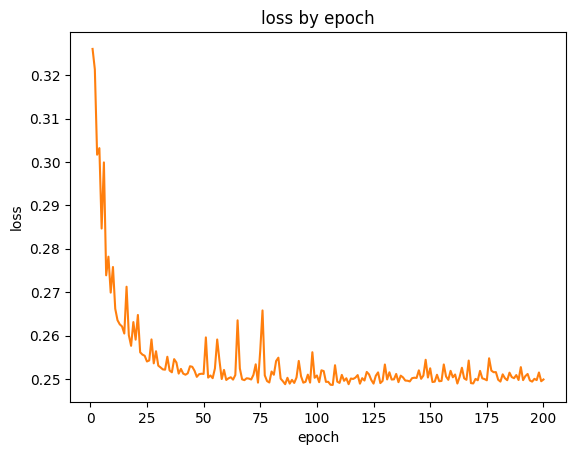

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, losses_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by epoch')
plt.show()

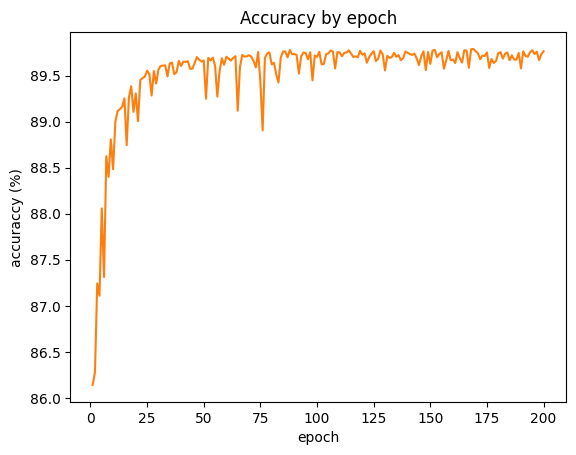

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, acc_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('accuraccy (%)')
plt.title('Accuracy by epoch')
plt.show()

In [16]:
model.load_state_dict(best_weights)

correct_test = 0
total_test = 0
outputs_test = torch.squeeze(model(X_gpu_test))
loss_test = criterion(outputs_test, y_gpu_test)

total_test += y_gpu_test.size(0)
correct_test += torch.eq(outputs_test.round(), y_gpu_test).sum()
accuracy_test = 100 * correct_test/total_test

In [17]:
accuracy_test.item()

89.729248046875

In [18]:
# model_path = '../model/torch_softmax_sgd_384'
# torch.save(model.state_dict(), model_path)

In [26]:
from torcheval.metrics import BinaryAUROC

In [28]:
metric = BinaryAUROC()
metric.update(outputs_test, y_gpu_test)

In [30]:
metric.compute().item()

0.9619949044125